Navigating Energy Risks Case Study

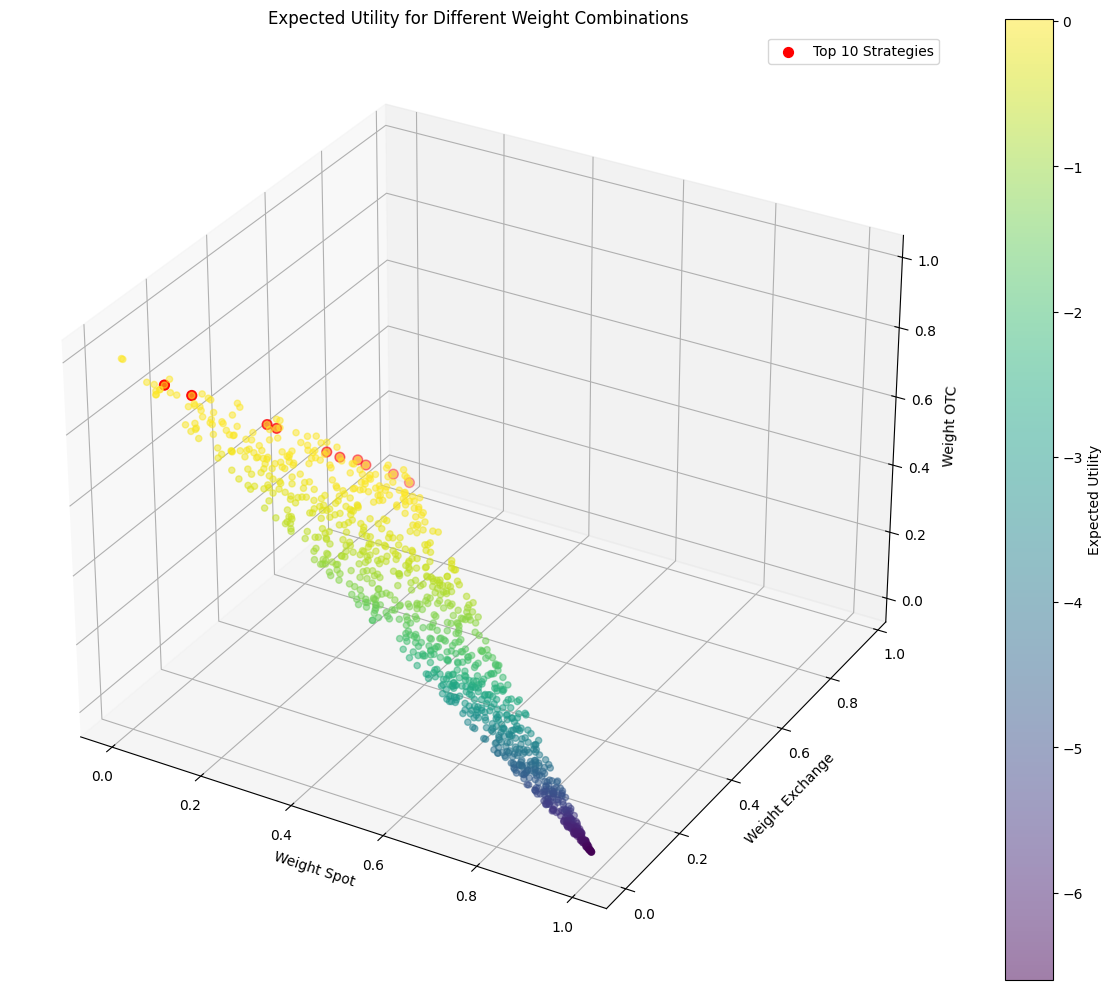

Top 10 Strategies:
 Weight Spot  Weight Exchange  Weight OTC  Expected Utility
    0.034395         0.180888    0.784717          0.012500
    0.041246         0.766218    0.192536          0.012495
    0.035035         0.093673    0.871291          0.012489
    0.043905         0.924722    0.031373          0.012473
    0.034220         0.461186    0.504594          0.012428
    0.033843         0.429552    0.536605          0.012425
    0.035859         0.876851    0.087291          0.012274
    0.034220         0.747600    0.218180          0.012244
    0.048551         0.613616    0.337833          0.011839
    0.049229         0.659278    0.291493          0.011807


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D

# Load spot price data
df = pd.read_excel(r"spot_prices_simulation_example.xlsx")

spot_values = df.iloc[:, 1].values[:]  # Extract spot values from the second column
spot_val = df.iloc[:, 1].values[1:]  # Exclude the first value
PnL_Spot_T = sum((3.4 / 1000) * (-9 + spot) for spot in spot_val)
# Note: The spot price model follows the one factor model of Schwartz (1997)

# Function to calculate forward prices
def calculate_forward_prices(S, T_values, kappa, alpha, sigma):
    forward_prices = {}
    for T in T_values:
        term1 = np.exp(-kappa * T) * np.log(S)
        term2 = (1 - np.exp(-kappa * T)) * alpha
        term3 = (sigma**2 * (1 - np.exp(-2 * kappa * T))) / (4 * kappa)
        forward_price = np.exp(term1 + term2 + term3)
        forward_prices[T] = forward_price
    return forward_prices

# Set parameters for forward price calculation
S = 10  # Spot price
T_values = list(range(1, 37))  # Time to maturity values
kappa, alpha, sigma = 0.15, 2.019899167, 0.2945  # Model parameters
yannual, T = 0.05, 36  # Annual yield and time to maturity

# Calculate OTC forward prices and PnL
forward_prices_OTC = calculate_forward_prices(S, T_values, kappa, alpha, sigma)
PnL_exchange_T = sum((3.4 / 1000) * (-9 + forward_prices_OTC[T]) for T in T_values)
PnL_OTC_T = PnL_exchange_T  # Assuming no counterparty default

# Calculate forward prices for all spot values
forward_prices = {i: calculate_forward_prices(spot_values[i], T_values, kappa, alpha, sigma) for i in range(len(spot_values))}

# Function to calculate cash balance
def calculate_cash_balance(yannual, forward_prices, T, spot_values):
    cashbalance = 0
    for t in range(1, T+1):
        inner_sum = 0
        I = 36 - t + 1
        for i in range(1, I+1):
            xa = i - 1
            if xa == 0:
                forward_diff = spot_values[t] - forward_prices[t-1][i]
            else:
                forward_diff = forward_prices[t][xa] - forward_prices[t-1][i]
            inner_sum += (np.exp(yannual/12) - 1) * max(forward_diff, 0)
        cashbalance += inner_sum
    return cashbalance * 3.4 / 1000

# Calculate cash balance
cashbalance_T = calculate_cash_balance(yannual, forward_prices, T, spot_values)

# Function to generate random weight values
def generate_random_values():
    while True:
        x = random.uniform(0, 1)
        y = random.uniform(0, 1 - x)
        z = 1 - x - y
        if 0 <= x <= 1 and 0 <= y <= 1 and 0 <= z <= 1:
            break
    return x, y, z

# Function to calculate total PnL
def calculate_pnl_total(weight_spot, weight_exchange, weight_OTC):
    return (weight_spot * PnL_Spot_T) + (weight_exchange * (PnL_exchange_T - cashbalance_T)) + (weight_OTC * PnL_OTC_T)

# Utility function
def utility_function(PnL_total, gamma=20):
    expected_pnl_total = np.mean(PnL_total)
    variance_pnl_total = np.var(PnL_total)
    expected_squared_pnl_total = np.mean(PnL_total ** 2)
    return expected_pnl_total - gamma * (variance_pnl_total + expected_squared_pnl_total)

# Perform Monte Carlo simulations
num_simulations = 1000
weights_spot, weights_exchange, weights_OTC, expected_utilities = [], [], [], []

for _ in range(num_simulations):
    weight_spot, weight_exchange, weight_OTC = generate_random_values()
    weights_spot.append(weight_spot)
    weights_exchange.append(weight_exchange)
    weights_OTC.append(weight_OTC)
    PnL_total = calculate_pnl_total(weight_spot, weight_exchange, weight_OTC)
    expected_utility = utility_function(PnL_total, gamma=20)
    expected_utilities.append(expected_utility)

# Create DataFrame with simulation results
results_df = pd.DataFrame({
    'Weight Spot': weights_spot,
    'Weight Exchange': weights_exchange,
    'Weight OTC': weights_OTC,
    'Expected Utility': expected_utilities
})

# Get top 10 strategies
top_10 = results_df.sort_values('Expected Utility', ascending=False).head(10)

# Create 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Highlight top 10 strategies
ax.scatter(top_10['Weight Spot'], top_10['Weight Exchange'], top_10['Weight OTC'], 
           c='red', s=50, label='Top 10 Strategies')

# Plot all strategies
scatter = ax.scatter(weights_spot, weights_exchange, weights_OTC, c=expected_utilities, cmap='viridis', alpha=0.5)

# Set labels and title
ax.set_xlabel('Weight Spot')
ax.set_ylabel('Weight Exchange')
ax.set_zlabel('Weight OTC')
ax.set_title('Expected Utility for Different Weight Combinations')

# Add color bar and legend
cbar = fig.colorbar(scatter)
cbar.set_label('Expected Utility')
ax.legend()

plt.tight_layout()
plt.show()

# Print top 10 strategies
print("Top 10 Strategies:")
print(top_10.to_string(index=False))

Plot of forward prices and spot prices at time 0

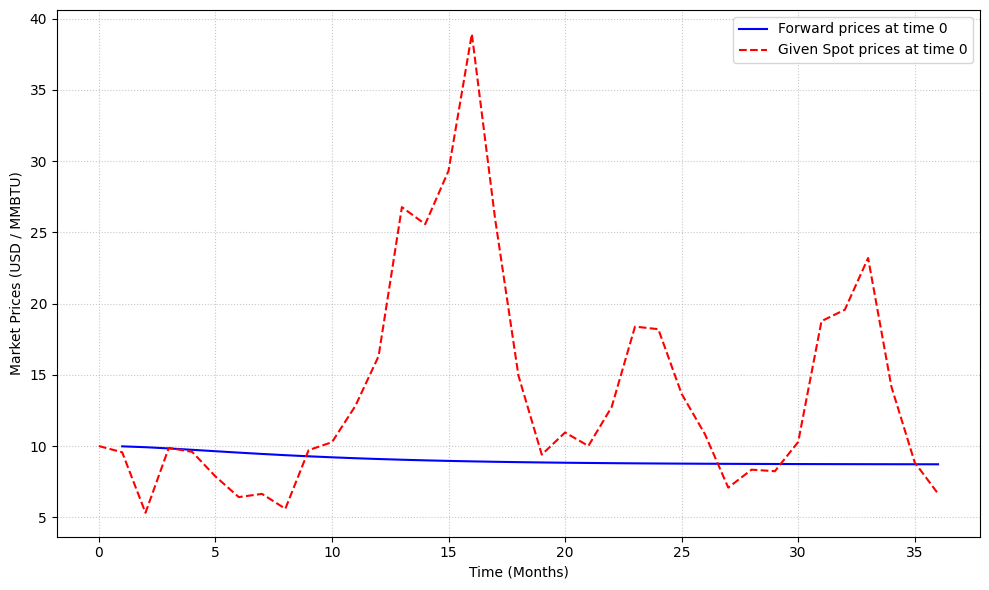

In [5]:
# Calculate forward prices using the previously defined function
forward_prices = calculate_forward_prices(S, T_values, kappa, alpha, sigma)

# Extract keys (T values) and values (Forward prices) from the dictionary
T_values = list(forward_prices.keys())
forward_price_values = list(forward_prices.values())

# Create a new figure with specified size
plt.figure(figsize=(10, 6))

# Plot forward prices
plt.plot(T_values, forward_price_values, linestyle='-', color='b', label='Forward prices at time 0')

# Plot spot prices from the dataframe
plt.plot(df['t'], df['spot'], linestyle='--', color='r', label='Given Spot prices at time 0')


plt.xlabel('Time (Months)')
plt.ylabel('Market Prices (USD / MMBTU)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()